# Content Preservation Metric Development

Our intended metric is an extension of the Word Movers Distance-based content preservation metric introduced by [Evaluating Style Transfer for Text](https://arxiv.org/pdf/1904.02295.pdf). However, we chose to replace logistic regression for feature importances with word attributions from the trained BERT style classifier. We also replace WMD for cosine similarity on SBert embeddings as it has shown improvements in accuracy and performance ([from blog](https://vaclavkosar.com/ml/Word-Movers-Embedding-Cheap-WMD-For-Documents)).

The general approach is to:

1. Build style lexicon from trained classifier feature importances
2. Use style lexicon to mask out all style tokens in the x and x’ (“removing the style, only content remains”)
3. Compare similarity/distance between these two “content only” sentences using cosine similarity between SBert embeddings

![](../images/content_preservation_score.jpeg)

Two things we need to figure out:
1. Does cosine similarity on [masked] SBert embeddings produce meaningful/expected measures of similarity
2. How do we precisely mask out __only__ the style related words?


In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Prove SBert works with `<MASK>` tokens in input and similarity metrics make sense

In [2]:
# from typing import List

# import torch
# import pandas as pd
# from tqdm import tqdm
# from transformers_interpret import SequenceClassificationExplainer
# from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification


# class ContentPreservationScorer:
#     """

#     Attributes:
#         sbert_model_identifier (str)

#     """

#     def __init__(self, cls_model_identifier: str, sbert_model_identifier: str):

#         self.cls_model_identifier = cls_model_identifier
#         self.sbert_model_identifier = sbert_model_identifier
#         self.device = torch.cuda.current_device() if torch.cuda.is_available() else -1

#         self._initialize_hf_artifacts()

#     def _initialize_hf_artifacts(self):
#         """
#         Initialize a HuggingFace artifacts (tokenizer and model) according
#         to the provided identifiers for both SBert and the classification model.
#         Then initialize the word attribution explainer with the HF model+tokenizer.

#         """

#         # sbert
#         self.sbert_tokenizer = AutoTokenizer.from_pretrained(
#             self.sbert_model_identifier
#         )
#         self.sbert_model = AutoModel.from_pretrained(self.sbert_model_identifier)

#         # classifer
#         self.cls_tokenizer = AutoTokenizer.from_pretrained(self.cls_model_identifier)
#         self.cls_model = AutoModelForSequenceClassification.from_pretrained(
#             self.cls_model_identifier
#         )
#         self.cls_model.to(self.device)
#         self.explainer = SequenceClassificationExplainer(
#             self.cls_model, self.cls_tokenizer
#         )

#     def compute_sentence_embeddings(self, input_text: List[str]) -> torch.Tensor:
#         """
#         Compute sentence embeddings for each sentence provided a list of text strings.

#         Args:
#             input_text (List[str]) - list of input sentences to encode

#         Returns:
#             sentence_embeddings (torch.Tensor)

#         """
#         # tokenize sentences
#         encoded_input = self.sbert_tokenizer(
#             input_text,
#             padding=True,
#             truncation=True,
#             max_length=256,
#             return_tensors="pt",
#         )

#         # to device
#         self.sbert_model.eval()
#         self.sbert_model.to(self.device)
#         encoded_input = {k: v.to(self.device) for k, v in encoded_input.items()}

#         # compute token embeddings
#         with torch.no_grad():
#             model_output = self.sbert_model(**encoded_input)

#         return (
#             self.mean_pooling(model_output, encoded_input["attention_mask"])
#             .detach()
#             .cpu()
#         )

#     def calculate_content_preservation_score(self):
#         pass

#     def calculate_feature_attribution_scores(
#         self, text: str, class_index: int = 0, as_norm: bool = False
#     ) -> List[tuple]:
#         """
#         Calcualte feature attributions using integrated gradients.

#         Args:
#             text (str) - text to get attributions for
#             class_index (int) - Optional output index to provide attributions for

#         """
#         attributions = self.explainer(text, index=class_index)

#         if as_norm:
#             idx, values = zip(*attributions)
#             df = pd.DataFrame(data=values, index=idx, columns=["score"])
#             df["abs_norm"] = df["score"].abs() / df["score"].abs().sum()
#             df = df.sort_values(by="abs_norm", ascending=False)
#             df["cumulative"] = df["abs_norm"].cumsum()
#             return df

#         return attributions

#     def visualize_feature_attribution_scores(self, text: str, class_index: int = 0):
#         """
#         Calculates and visualizes feature attributions using integrated gradients.

#         Args:
#             text (str) - text to get attributions for
#             class_index (int) - Optional output index to provide attributions for

#         """
#         self.explainer(text, index=class_index)
#         self.explainer.visualize()

#     @staticmethod
#     def cosine_similarity(tensor1: torch.Tensor, tensor2: torch.Tensor) -> List[float]:
#         """ """

#         assert tensor1.shape == tensor2.shape

#         # ensure 2D tensor
#         if tensor1.ndim == 1:
#             tensor1 = tensor1.unsqueeze(0)
#             tensor2 = tensor2.unsqueeze(0)

#         cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
#         return cos_sim(tensor1, tensor2).tolist()

#     @staticmethod
#     def mean_pooling(model_output, attention_mask):
#         """
#         Peform mean pooling over token embeddings to create sentence embedding. Here we take
#         the attention mask into account for correct averaging on active token positions.

#         CODE BORROWED FROM:
#             https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers

#         """

#         token_embeddings = model_output[
#             0
#         ]  # First element of model_output contains all token embeddings
#         input_mask_expanded = (
#             attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#         )
#         sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
#         sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

#         return sum_embeddings / sum_mask

In [4]:
from src.inference import ContentPreservationScorer

SBERT_MODEL_PATH = "sentence-transformers/all-MiniLM-L6-v2"
CLS_MODEL_PATH = (
    "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466"
)
cps = ContentPreservationScorer(
    sbert_model_identifier=SBERT_MODEL_PATH, cls_model_identifier=CLS_MODEL_PATH
)

In [5]:
test = "david crane, born august 10, 1957, is an extremely successful american writer and producer."
test2 = "david crane, born august 10, 1957, is an [MASK] [MASK] american writer and producer."
test3 = "david crane, born august 10, 1957, is an [MASK] [MASK] producer."
test4 = "in 2011 he followed up this debacle with anther rude letter to a constituent."
test5 = "he born august 10, 1957, is an [MASK] [MASK] american writer and producer."

#### Check that tokenizer handels [MASK] appropriately

In [6]:
cps.sbert_tokenizer.encode(test)

[101,
 2585,
 11308,
 1010,
 2141,
 2257,
 2184,
 1010,
 3890,
 1010,
 2003,
 2019,
 5186,
 3144,
 2137,
 3213,
 1998,
 3135,
 1012,
 102]

In [7]:
103 in cps.sbert_tokenizer.encode(test2)

True

#### Check that embedding similarity makes sense with [MASK] tokens

In [79]:
embeddings = cps.compute_sentence_embeddings([test, test2, test3, test4, test5])

In [84]:
embeddings[0:2].shape

torch.Size([2, 384])

In [86]:
cps.cosine_similarity(embeddings[0:2], embeddings[2:4])

[0.05591192841529846, 0.07668484002351761]

In [9]:
# check that embeddings are deterministic with MASKs
cps.cosine_similarity(embeddings[0], embeddings[0])

[1.0]

In [10]:
# check if cosine similarity is symmetric
cps.cosine_similarity(embeddings[0], embeddings[1]), cps.cosine_similarity(
    embeddings[1], embeddings[0]
)

([0.6621647477149963], [0.6621647477149963])

In [11]:
# check that test2/test3 are more similar than test2/test4
cps.cosine_similarity(embeddings[1], embeddings[2]), cps.cosine_similarity(
    embeddings[2], embeddings[3]
)

([0.9872645735740662], [0.06394388526678085])

**NOTE:** Looks like the tokenizer can appropriately handle [MASK] special tokens in input text and maintains a reasonable understanding of similarity. Will need to further vet this with real TST examples during evaluation...

### Key Question: Is style masking or style removal more effective at producing similar embeddings?

From the paper: With respect to text modification, style masking may be more suitable as it, on average for WMD, exhibits a higher correlation with human judgments.



#### Style Masking

In [12]:
# original
xs = "Harvard is a beautiful school."
xn = "Harvard is a school."
embeddings = cps.compute_sentence_embeddings([xs, xn])

In [13]:
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.8552916049957275]

In [14]:
# masked
xs = "Harvard is a [MASK] school."
xn = "Harvard is a school."
embeddings = cps.compute_sentence_embeddings([xs, xn])

In [15]:
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.7207826972007751]

In [16]:
# padded???
xs = "Harvard is a [PAD] school."
xn = "Harvard is a school."
embeddings = cps.compute_sentence_embeddings([xs, xn])

In [17]:
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.9652663469314575]

**Observation:** 
- It appears that `[MASK]` replacements result in lower similarity than the original... this is not what we want.
- In this example, since we just have a single style word, removal will result in an identical sentence with identical embeddings.
- It looks like the `[PAD]` (or empty) token actually works pretty well here


#### Style Removal

What about sentences that are more complex...

In [18]:
# baseline
xs = "double indemnity is perhaps the most well known, definitive example of a genre of films called film noir."
xn = "double indemnity is an example of a genre of films called film noir."
embeddings = cps.compute_sentence_embeddings([xs, xn])
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.9796276092529297]

In [19]:
# masking
xs = "double indemnity is perhaps the [MASK] [MASK] [MASK] [MASK] [MASK] example of a genre of films called film noir."
xn = "double indemnity is an example of a genre of films called film noir."
embeddings = cps.compute_sentence_embeddings([xs, xn])
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.6714310050010681]

In [20]:
# removal
xs = "double indemnity is perhaps the example of a genre of films called film noir."
xn = "double indemnity is an example of a genre of films called film noir."
embeddings = cps.compute_sentence_embeddings([xs, xn])
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.9909889698028564]

In [21]:
# pad
xs = "double indemnity is perhaps the [PAD] [PAD] [PAD] [PAD] [PAD] example of a genre of films called film noir."
xn = "double indemnity is an example of a genre of films called film noir."
embeddings = cps.compute_sentence_embeddings([xs, xn])
cps.cosine_similarity(embeddings[0], embeddings[1])

[0.9467359185218811]

Will need to experiment more with both PAD and removal...as of now, looks like removal might better??

## Build style lexicon for the WNC corpus using word attributions from fine-tuned Style Classificaiton transfomer

### First, let's get Integrated Gradients working with Captum + Transformers-Interpret

**Integrated gradients** is a method originally proposed in Sundararajan et al., “Axiomatic Attribution for Deep Networks” that aims to attribute an importance value to each input feature of a machine learning model based on the gradients of the model output with respect to the input. In particular, integrated gradients defines an attribution value for each feature by considering the integral of the gradients taken along a straight path from a baseline instance  to the input instance.

1. First generate a  "baseline input" (informationless) of same size as input example. 
    - For images, all black picture or random pixels. 
    - For text, a squence of [PAD] tokens. Ex: `[CLS] + [PAD]*(seq_len-2) + [SEP]`
2. Then, generate a linear interpolation between the baseline and the original image. You can think of interpolated images as small steps in the feature space between your baseline and input.

![](./images/cat_interp.png)

3. Calculate gradients at each step between output predictions with respect to input features. Here a step is a process of introducing more and more information with regards to baseline input. N_steps is a tunable parameter (50 - 300)
4. Approximate the integral between your baseline and input by accumulating (cumulative average) these local gradients.


Integrated Gradients satisfy both of the following principles and thus represent a good attribution method:

- Sensitivity: If an input feature changes the classification score in any way, this input should have an attribution value not equal to 0.
- Implementation invariance: The result of the attribution should not depend on the design and structure of the neural network. Thus, if two different neural networks provide the same prediction for the same inputs, their attribution values should also be identical.

In this case, we are using `captum.attr.LayerIntegratedGradients` as this allows us to specify a specific layers' inputs/features for which we should assign an importance (attribution) score for. The embedding layer is a standard choice since we can not compute attributions for the raw input due to its discrete structure (i.e., we cannot differentiate the output of the model with respect to the discrete input representation). So we calculate attributions of the output with respect to the embedding layer.

In [23]:
# !pip3 install transformers-interpret
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

DEVICE = torch.cuda.current_device() if torch.cuda.is_available() else -1
CLS_MODEL_PATH = (
    "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466"
)

In [24]:
# initialize model
model = AutoModelForSequenceClassification.from_pretrained(CLS_MODEL_PATH)
model.to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(CLS_MODEL_PATH)

In [25]:
test = "there is an iconic roadhouse, named 'spud's roadhouse', which sells fuel and general shop items , has great meals and has accommodation."
test = "chemical abstracts service (cas), a division of the american chemical society, is considered the world's leading source of chemical information."
test = "Harvard is a beautiful school."
test = " while this subjective assignment of probabilities works well for rolling dice and lotteries, it could also lead to the conclusion that the sun is as likely to rise as to not rise tomorrow morning."

In [26]:
test

' while this subjective assignment of probabilities works well for rolling dice and lotteries, it could also lead to the conclusion that the sun is as likely to rise as to not rise tomorrow morning.'

In [27]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)
word_attributions = cls_explainer(test)

In [28]:
cls_explainer.predicted_class_index

array(1)

Positive attribution numbers indicate a word contributes positively towards the predicted class, while negative numbers indicate a word contributes negatively towards the predicted class.

In [29]:
word_attributions

[('[CLS]', 0.0),
 ('while', -0.05562276560527483),
 ('this', 0.31572708215573253),
 ('subjective', -0.8101973803499191),
 ('assignment', 0.03173935615089209),
 ('of', 0.02112331660612022),
 ('pro', 0.16803625226122712),
 ('##ba', -0.018405146228170802),
 ('##bilities', 0.08167633396706857),
 ('works', 0.0563545170894699),
 ('well', 0.13795646377426188),
 ('for', 0.04543423120455286),
 ('rolling', 0.07429776432569471),
 ('dice', 0.046204336916178465),
 ('and', -0.013798630256154106),
 ('lot', 0.09643428609621504),
 ('##ter', 0.008971655794682445),
 ('##ies', 0.01728700645220686),
 (',', -0.08273477807915612),
 ('it', 0.07640487502611108),
 ('could', 0.16356631829091245),
 ('also', 0.20277085910904877),
 ('lead', -0.006952292595890877),
 ('to', 0.09858786597049837),
 ('the', 0.005357464683234663),
 ('conclusion', 0.021443037809708222),
 ('that', -0.009867101889515595),
 ('the', 0.06205404295747667),
 ('sun', 0.09670662006933084),
 ('is', 0.08571196298974545),
 ('as', 0.0505901646890793),

Sometimes the numeric attributions can be difficult to read particularly in instances where there is a lot of text. To help with that we also provide the visualize() method that utilizes Captum's in built viz library to create a HTML file highlighting the attributions.

By default, attributions are always calculated with respect to the predicted class (0 in this case)

In [31]:
cls_explainer.visualize()

**Explaining Attributions for Non Predicted Class** <br>
Attribution explanations are not limited to the predicted class. Let's test a more complex sentence that contains mixed sentiments.

In the example below we pass class_index=1 as an argument indicating we would like the attributions to be explained for the NEUTRAL class regardless of what the actual prediction is. Effectively because this is a binary classifier we are getting the inverse attributions.

In [32]:
%%time
cls_explainer_inverse = SequenceClassificationExplainer(model, tokenizer)
word_attributions_inverse = cls_explainer_inverse(test, index=1)

CPU times: user 150 ms, sys: 29.2 ms, total: 180 ms
Wall time: 177 ms


In [33]:
cls_explainer_inverse.visualize()

In [34]:
word_attributions_inverse

[('[CLS]', 0.0),
 ('while', -0.05562276560527483),
 ('this', 0.31572708215573253),
 ('subjective', -0.8101973803499191),
 ('assignment', 0.03173935615089209),
 ('of', 0.02112331660612022),
 ('pro', 0.16803625226122712),
 ('##ba', -0.018405146228170802),
 ('##bilities', 0.08167633396706857),
 ('works', 0.0563545170894699),
 ('well', 0.13795646377426188),
 ('for', 0.04543423120455286),
 ('rolling', 0.07429776432569471),
 ('dice', 0.046204336916178465),
 ('and', -0.013798630256154106),
 ('lot', 0.09643428609621504),
 ('##ter', 0.008971655794682445),
 ('##ies', 0.01728700645220686),
 (',', -0.08273477807915612),
 ('it', 0.07640487502611108),
 ('could', 0.16356631829091245),
 ('also', 0.20277085910904877),
 ('lead', -0.006952292595890877),
 ('to', 0.09858786597049837),
 ('the', 0.005357464683234663),
 ('conclusion', 0.021443037809708222),
 ('that', -0.009867101889515595),
 ('the', 0.06205404295747667),
 ('sun', 0.09670662006933084),
 ('is', 0.08571196298974545),
 ('as', 0.0505901646890793),

In [35]:
model.get_input_embeddings()

Embedding(30522, 768, padding_idx=0)

### ~~Build a style lexicon~~

Let's assemble a style lexicon from feature attributions using integrated gradients from our BERT model that was trained for text classification on WNC. To do so, we'll:
- Aggregate token attribution scores for each token across all sentences in the training dataset (upon which the model was trained).
- Attribution scores for each feature will be calculated based on a fixed class target (class 0: subjective) to ensure consistent attribution direction
- We will populate the lexicon with features/tokens having the highest absolute average score

#### **OLD StyleLexicon Class**

In [140]:
# from typing import List
# from collections import defaultdict

# import torch
# from tqdm import tqdm
# import pandas as pd
# from datasets import load_from_disk
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# from transformers_interpret import SequenceClassificationExplainer


# class StyleLexicon:
#     def __init__(
#         self,
#         model_identifier: str,
#         dataset_identifier: str,
#     ):
#         self.model_identifier = model_identifier
#         self.dataset_identifier = dataset_identifier
#         self.device = torch.cuda.current_device() if torch.cuda.is_available() else -1

#         self._initialize_hf_artifacts()
#         self._construct_dataloader()

#     def _initialize_hf_artifacts(self):
#         """
#         Initialize a HuggingFace dataset, tokenizer, and model according
#         to the provided identifier. Then initialize the word attribution
#         explainer with the huggingface model+tokenizer

#         """
#         self.dataset = load_from_disk(self.dataset_identifier)
#         self.tokenizer = AutoTokenizer.from_pretrained(self.model_identifier)
#         self.model = AutoModelForSequenceClassification.from_pretrained(
#             self.model_identifier
#         )
#         self.model.to(self.device)
#         self.explainer = SequenceClassificationExplainer(self.model, self.tokenizer)

#     def _construct_dataloader(self):
#         """
#         Initialize the dataloader on train dataset.

#         Note: Here we are batching untokenized sentences since the downstream
#         SequenceClassificationExplainer operates on raw text. Note batch size of
#         just 1 due to limitations of SequenceClassificationExplainer in handling batches.

#         """
#         self.dataloader = torch.utils.data.DataLoader(
#             self.dataset["train"],
#             batch_size=1,
#             drop_last=False,
#             pin_memory=True,
#             shuffle=False,
#         )

#     def calculate_feature_attribution_scores(
#         self, text: str, class_index: int = 0, as_norm: bool = False
#     ) -> List[tuple]:
#         """
#         Calcualte feature attributions using integrated gradients.

#         Args:
#             text (str) - text to get attributions for
#             class_index (int) - Optional output index to provide attributions for

#         """
#         attributions = self.explainer(text, index=class_index)

#         if as_norm:
#             idx, values = zip(*attributions)
#             df = pd.DataFrame(data=values, index=idx, columns=["score"])
#             df["abs_norm"] = df["score"].abs() / df["score"].abs().sum()
#             df = df.sort_values(by="abs_norm", ascending=False)
#             df["cumulative"] = df["abs_norm"].cumsum()
#             return df

#         return attributions

#     def visualize_feature_attribution_scores(self, text: str, class_index: int = 0):
#         """
#         Calculates and visualizes feature attributions using integrated gradients.

#         Args:
#             text (str) - text to get attributions for
#             class_index (int) - Optional output index to provide attributions for

#         """
#         self.explainer(text, index=class_index)
#         self.explainer.visualize()

#     def collect_feature_attribution_scores(self):

#         score_collection = defaultdict(list)

#         for i, batch in enumerate(tqdm(self.dataloader)):

#             text = batch["text"][0]
#             attributions = self.calculate_feature_attribution_scores(text)
#             for token, score in attributions:
#                 score_collection[token].append(score)

#             if i == 5000:
#                 break
#         return score_collection

In [141]:
# CLS_DATASET_PATH = "/home/cdsw/data/processed/WNC_cls_full"
# CLS_MODEL_PATH = (
#     "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466"
# )
# style_lexicon = StyleLexicon(
#     model_identifier=CLS_MODEL_PATH, dataset_identifier=CLS_DATASET_PATH
# )

### Perform "Token Style Masking" on a per sentence basis rather than with lexicon dictionary lookup

By trying to create a style lexicon, all we really are doing is aggregating high fidelity, local feature importances into low fidelity, global feature importances. This aggregation results in significant information loss, and in fact, kind of negates the power of using a contextual embedding model like BERT in the first place.

Instead, we will take advantage of the contextual details and mask/remove tokens on a per sentence basis using word attribution scores as the signal for which tokens to mask/remove. This leaves a few open questions:
- What thresholds on word attribution scores for masking?
- What threshold on number of words for masking?
- Can I develop these based on looking at distributions from train set?


**Options:**
1. [MEH] Find word attribution score outliers in each sentence using IQR.
    - Problem is that most of these won't have an outlier by this definition.
    - So, we'd have to change 1.5*IQR to something more lenient (like 1.1*IQR).. this is arbitrary and will be different for each.
2. [BAD] Mask top N words proportional to length of sentence
    - Problem is that long sentence could have just 1 really strong style word and we'd be masking a number of tokens erroneously just because of length
    - Also choosing number of tokens to mask by lenght is arbitrary.
3. [MAYBE OK] Mask all tokens that represent up to top X% of style attribution. Or just top token if top token accounts for more than X%.
    - Better because it doesn't enforce hard rule on number of tokens to mask
    - Rather its however many tokens make up the strongest X% of style attribution
    - Problem is still arbitrary determination of that X% threshold...also if no strong style words, then we mask MANY tokens
    - Select X to err on the side of precision like the paper --> "We opt for higher precision and lower recall to minimize the risk of removing content words, which are essential to evaluations of content preservation"


### Examples

#### Ex1

- "contagious" gets broken up and only the latter parts of the word are considered subejctive...
- "pop" is considered to be subjective??

In [36]:
ex1_s = (
    "the band plays an engaging and contagious rhythm known as brega pop and calypso."
)
ex1_n = "the band plays a rhythm known as brega pop and calypso."

In [37]:
cps.visualize_feature_attribution_scores(ex1_s)
t = cps.calculate_feature_attribution_scores(ex1_s, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.99),LABEL_0,1.01,[CLS] the band plays an engaging and con ##tag ##ious rhythm known as br ##ega pop and cal ##yp ##so . [SEP]


<AxesSubplot:>

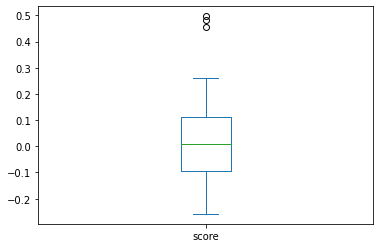

In [38]:
t.score.plot(kind="box")

In [39]:
t.score

9     0.496893
8     0.482248
15    0.455500
2     0.260220
10   -0.258252
4    -0.237123
19    0.164310
7    -0.137872
3     0.134762
12   -0.131099
18   -0.114123
11   -0.097646
20   -0.086629
6    -0.058542
1     0.043909
16    0.041001
17   -0.035094
13    0.034263
5     0.033845
14    0.020360
0     0.000000
21    0.000000
Name: score, dtype: float64

In [40]:
cps.visualize_feature_attribution_scores(ex1_n)
cps.calculate_feature_attribution_scores(ex1_n, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.01),LABEL_0,-2.61,[CLS] the band plays a rhythm known as br ##ega pop and cal ##yp ##so . [SEP]


,token,score,abs_norm,cumulative
4,a,-0.686558,0.260588,0.260588
6,known,-0.401658,0.152452,0.413040
5,rhythm,-0.380303,0.144347,0.557386
2,band,-0.319601,0.121307,0.678693
1,the,-0.272519,0.103436,0.782129
11,and,-0.117419,0.044567,0.826696
7,as,-0.110312,0.041869,0.868566
13,##yp,-0.082348,0.031256,0.899822
14,##so,-0.070352,0.026703,0.926524
3,plays,-0.059806,0.022700,0.949224


#### Ex2
- Gets prestigious and moving as subjective modifiers.
- However, also things "parents" is a subjective term...

In [41]:
ex2_s = "building a difference received the prestigious seal of approval from the parents television council for the moving episode 'page-bailie bunch'."
ex2_n = "building a difference received the seal of approval from the parents television council for the episode 'page-bailie bunch'."

In [42]:
cps.visualize_feature_attribution_scores(ex2_s)
cps.calculate_feature_attribution_scores(ex2_s, as_norm=True)

,token,score,abs_norm,cumulative
17,moving,0.685320,0.206718,0.206718
12,parents,0.400371,0.120767,0.327485
6,prestigious,0.310053,0.093524,0.421009
16,the,-0.275444,0.083084,0.504093
18,episode,-0.219552,0.066225,0.570318
24,bunch,-0.168132,0.050715,0.621033
13,television,-0.161920,0.048841,0.669874
11,the,-0.135195,0.040780,0.710654
14,council,-0.126225,0.038074,0.748728
4,received,0.123276,0.037185,0.785913


In [43]:
cps.visualize_feature_attribution_scores(ex2_n)
cps.calculate_feature_attribution_scores(ex2_n, as_norm=True)

,token,score,abs_norm,cumulative
11,parents,0.495839,0.130589,0.130589
12,television,-0.474559,0.124985,0.255573
17,',-0.307276,0.080927,0.336501
10,the,-0.302337,0.079626,0.416127
18,page,-0.273191,0.071950,0.488077
15,the,-0.220890,0.058176,0.546253
3,difference,-0.209422,0.055155,0.601408
5,the,-0.195728,0.051549,0.652957
16,episode,-0.169463,0.044631,0.697589
4,received,-0.148648,0.039149,0.736738


#### Ex3

In [3]:
ex3_s = "water from a fire sprinkler system explosion in 2007"
ex3_n = "water from a fire sprinkler system failure in 2007"

In [45]:
cps.visualize_feature_attribution_scores(ex3_s)
cps.calculate_feature_attribution_scores(ex3_s, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.37),LABEL_0,-0.74,[CLS] water from a fire sp ##rin ##kle ##r system explosion in 2007 [SEP]


,token,score,abs_norm,cumulative
10,explosion,-0.760934,0.315235,0.315235
9,system,-0.445005,0.184353,0.499588
12,2007,-0.342561,0.141914,0.641502
3,a,0.179300,0.074279,0.715781
2,from,0.146276,0.060598,0.776379
1,water,0.132378,0.054841,0.831220
5,sp,0.130931,0.054241,0.885461
8,##r,0.083237,0.034483,0.919944
7,##kle,0.070713,0.029295,0.949239
6,##rin,0.057522,0.023830,0.973069


In [46]:
cps.visualize_feature_attribution_scores(ex3_n)
cps.calculate_feature_attribution_scores(ex3_n, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.17),LABEL_0,-1.82,[CLS] water from a fire sp ##rin ##kle ##r system failure in 2007 [SEP]


,token,score,abs_norm,cumulative
10,failure,-0.651508,0.261295,0.261295
9,system,-0.468426,0.187868,0.449163
4,fire,-0.375742,0.150696,0.599859
11,in,-0.295798,0.118633,0.718493
12,2007,0.263430,0.105652,0.824145
3,a,-0.212420,0.085194,0.909338
6,##rin,-0.086336,0.034626,0.943964
2,from,-0.056183,0.022533,0.966497
1,water,0.037709,0.015124,0.981620
5,sp,0.026214,0.010513,0.992134


#### Ex4

In [47]:
ex4_s = "the leela group has commissioned a 1.37 lakh sq ft state of the art building."
ex4_n = "the leela group has commissioned a 1.37 lakh sq ft building."

In [48]:
cps.visualize_feature_attribution_scores(ex4_s)
cps.calculate_feature_attribution_scores(ex4_s, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.99),LABEL_0,0.26,[CLS] the lee ##la group has commissioned a 1 . 37 la ##kh sq ft state of the art building . [SEP]


,token,score,abs_norm,cumulative
18,art,0.736597,0.255327,0.255327
6,commissioned,0.354312,0.122815,0.378142
15,state,0.333868,0.115729,0.493871
17,the,-0.278532,0.096547,0.590418
4,group,-0.215907,0.074840,0.665258
7,a,-0.170277,0.059023,0.724281
20,.,-0.155104,0.053764,0.778045
19,building,-0.120421,0.041742,0.819786
5,has,-0.090933,0.031520,0.851306
13,sq,-0.075807,0.026277,0.877584


In [49]:
cps.visualize_feature_attribution_scores(ex4_n)
cps.calculate_feature_attribution_scores(ex4_n, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.03),LABEL_0,-2.08,[CLS] the lee ##la group has commissioned a 1 . 37 la ##kh sq ft building . [SEP]


,token,score,abs_norm,cumulative
7,a,-0.553373,0.188336,0.188336
5,has,-0.506389,0.172346,0.360682
4,group,-0.372519,0.126784,0.487466
15,building,-0.342775,0.116661,0.604127
6,commissioned,0.277783,0.094541,0.698668
1,the,-0.212587,0.072352,0.771020
3,##la,-0.131129,0.044629,0.815649
13,sq,-0.107308,0.036522,0.852171
2,lee,-0.095123,0.032375,0.884545
12,##kh,-0.085631,0.029144,0.913689


#### Ex4

In [50]:
ex5_s = "singapore has a highly developed and successful market economy."
ex5_n = "singapore has a highly developed trade-oriented market economy."

In [51]:
cps.visualize_feature_attribution_scores(ex5_s)
cps.calculate_feature_attribution_scores(ex5_s, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.69),LABEL_0,0.11,[CLS] singapore has a highly developed and successful market economy . [SEP]


,token,score,abs_norm,cumulative
7,successful,-0.808754,0.376367,0.376367
2,has,0.337286,0.156962,0.533328
1,singapore,0.323927,0.150745,0.684073
9,economy,0.278802,0.129745,0.813818
4,highly,-0.172768,0.080400,0.894219
5,developed,0.125653,0.058475,0.952693
6,and,0.054474,0.025350,0.978043
3,a,-0.025629,0.011927,0.989970
10,.,-0.011578,0.005388,0.995358
8,market,0.009975,0.004642,1.000000


In [52]:
cps.visualize_feature_attribution_scores(ex5_n)
cps.calculate_feature_attribution_scores(ex5_n, as_norm=True)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.27),LABEL_0,-1.06,[CLS] singapore has a highly developed trade - oriented market economy . [SEP]


,token,score,abs_norm,cumulative
4,highly,-0.924491,0.479649,0.479649
6,trade,-0.207859,0.107842,0.587491
1,singapore,0.183225,0.095062,0.682553
9,market,-0.144004,0.074713,0.757266
2,has,0.131890,0.068428,0.825694
8,oriented,-0.113468,0.058870,0.884563
5,developed,-0.104355,0.054142,0.938706
10,economy,0.077393,0.040154,0.978859
7,-,0.019251,0.009988,0.988847
3,a,0.015799,0.008197,0.997044


**Open Questions**
1. Does style token __masking__ or __removal__ retain more meaningful sentence embeddings for similarity?
2. How do we determine which tokens should be masked/removed from each subjective/neutral sentence?
    - What thresholds on word attribution scores?
    - What threshold on number of words?
    - Can I develop these based on looking at distributions from train set?
3. Is there any good way to quantitatively assess these tradeoffs other than manual inspection? It seems like no...
    - The only way I could think is to draw correlations between automated metrics and human evaluation like the paper does, but that requires human evaluation...
    - We also can draw high level conclusions by comparing scores against the ground truth annotation. For example, CPS (averaged across the test dataset) on input -> generated text should score worse than CPS on input -> ground truth annotation.


### Put it all together

In [1]:
from src.inference import ContentPreservationScorer

SBERT_MODEL_PATH = "sentence-transformers/all-MiniLM-L6-v2"
CLS_MODEL_PATH = (
    "../models/TRIAL-J-shuffle-lr_3en06-epoch_15-wd_.1-bs_32/checkpoint-67466"
)
cps = ContentPreservationScorer(
    sbert_model_identifier=SBERT_MODEL_PATH, cls_model_identifier=CLS_MODEL_PATH
)

In [5]:
ex3_n

'water from a fire sprinkler system failure in 2007'

In [6]:
cps.mask_style_tokens(ex3_n, mask_type="remove", threshold=0.5)

'water from a fire sprinkler in 2007'

In [8]:
inp = [
    "singapore has a highly developed and successful market economy.",
    "double indemnity is perhaps the most well known, definitive example of a genre of films called film noir.",
]
out = [
    "singapore has a highly developed trade-oriented market economy.",
    "double indemnity is an example of a genre of films called film noir.",
]

cps.calculate_content_preservation_score(inp, out, mask_type="pad", threshold=0.3)

[0.9008933305740356, 0.9662930369377136]

In [9]:
cps.calculate_content_preservation_score(inp, out, mask_type="remove", threshold=0.3)

[0.8853696584701538, 0.963718831539154]

In [10]:
cps.cosine_similarity(
    cps.compute_sentence_embeddings(inp), cps.compute_sentence_embeddings(out)
)

[0.9066721200942993, 0.9796274304389954]

Experimentally determine the best value parameters:

0. implement the ability to remove tokens along with [PAD]-ing them
1. Search through values of `threshold` (0 --> 0.5 by 0.05, maybe?) and `mask_type` ([PAD] vs. removal) to see how many tokens get removed on average (other stats)
2. For each threshold, calculate downstream impact on cosine similarity on sentence pairs (CPS score) -- use that to compare against baseline (no removal). See which threshold value (if any) produce "better" similarity scores.
3. During the experiments collect metric for number of tokens were masked that were "sub-tokens" (i.e. start with ##)